In [1]:
import os,sys
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import json
import pymongo
from sklearn.metrics import confusion_matrix
import itertools
from IPython.display import clear_output
from itertools import chain
from collections import Counter
from datetime import timedelta, datetime
from dateutil.relativedelta import relativedelta
import random as rnd
from bson import ObjectId
import matplotlib.dates as mdates
import pickle, gzip
import time
import math 
#import matplotlib.dates as 
from sklearn.model_selection import GridSearchCV
import seaborn as sns; sns.set()
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


# Random Forest binary classificator

The question is: **"is it possible to build a model able to predict if a track
will have a popularity above or below the mean trend, i.e. if its associated black
line will be above the red one ?"** We know that a Random Forest algorithm can be
trained to perform this task. First, we assign to each track of the data-set a binary
variable φ = 0,1: if during the first week the track has a popularity greater than
the average value then φ = 1, otherwise φ = 0. If during the first week the index
results to be above the red line for some days and below for the remaining days,
the variable φ is assigned just on a majority criterion.

In [2]:
path_proj = os.getcwd()+ '/'
path_save = path_proj + 'csv/'
figure_save = path_proj + 'figures'
#print(path_save)

In [3]:
df_track = pd.read_csv(path_save + 'df_track+.csv')# tracks' data frame

In [4]:
df_track.head()

,Unnamed: 0,id,name,type,added_at,album_id,album_name,artist_id,artist_name,disc_number,...,track_id,day_zero,1week,2week,3week,4week,artist_popularity,dzRank,dzArtFanN,dzAlbumN
0,0,003VDDA7J3Xb2ZFlNx7nIZ,YELL OH,track,2020-03-20T04:01:00Z,2orYogfKeURqyS1hRP1vZ4,YELL OH,6Xgp2XMz1fhVYe7i6yNAax,Trippie Redd,1,...,003VDDA7J3Xb2ZFlNx7nIZ,2020-02-07,1.0,1.0,1.0,1.0,92.0,100000.0,147721.0,26.0
1,1,00HxGKTPOh701Wv2gmbuA9,valentine's day,track,2020-02-10T18:00:06Z,17DTCLkdvszFaSgSv6areW,valentine's day,0duLKMlcwhyZgqu8zSSjBp,Alaina Castillo,1,...,00HxGKTPOh701Wv2gmbuA9,2020-01-24,1.0,1.0,1.0,1.0,55.0,100000.0,216.0,3.0
2,2,00SiZEELZ0K4gkUl0rU529,Bandsville,track,2020-02-20T23:01:00Z,1oxxysQmylUXuxzSdHlqUc,Baby Gravy 2,2YOYua8FpudSEiB9s88IgQ,Yung Gravy,1,...,00SiZEELZ0K4gkUl0rU529,2020-02-14,1.0,1.0,1.0,1.0,81.0,100000.0,12174.0,17.0
3,3,00WSG2jWrgq8Ln8lVLEkOr,3.5.7,track,2020-03-09T09:51:40Z,7GbL3PFtyrG8xT85SrYvms,3.5.7,4MRRW42s9ymwa5zu4xTKJh,Kaza,1,...,00WSG2jWrgq8Ln8lVLEkOr,2020-02-07,1.0,1.0,1.0,1.0,64.0,750996.0,62644.0,8.0
4,4,00dlNWEiPTtm1ldy6zOUlz,Cita,track,2020-03-10T16:18:32Z,701SovA1xH6bKc98mQJ3HI,Cita,3MHaV05u0io8fQbZ2XPtlC,Prince Royce,1,...,00dlNWEiPTtm1ldy6zOUlz,2020-02-01,1.0,1.0,1.0,1.0,82.0,NaN,1938957.0,29.0


In [8]:

cleaned_df = [df_track for k in range(4)]
labels = [[] for k in range(4)]
week_columns = ['1week','2week','3week','4week']
# Extract the labels
for i,i_th_week in enumerate(week_columns):
    cleaned_df[i] = df_track[df_track[i_th_week]>=-1] #considering tracks which have a not nan value for the field describing
    cleaned_df[i] = cleaned_df[i].select_dtypes('number') #the popularity of a track at the i-th week with respect to the average trend of the sample
    labels[i] = np.array(cleaned_df[i].pop(i_th_week))
    #drop some "useless" columns
    cleaned_df[i] = cleaned_df[i].drop(columns = ['dz_artist_id', 'dz_album_id',
                        'dz_track_id', 'dzTrackPos'] + [w  for w in week_columns if w!=i_th_week])

## Splitting dataset in train & test set

In [13]:
RSEED = 100
# splitting dataset 30% examples in test data
train, test, train_labels, test_labels = train_test_split(cleaned_df[0], labels[0], 
                                                          stratify = labels[0],
                                                          test_size = 0.3 
                                                          )
train = train.fillna(train.mean()) #for each feature, missing values are replaced with the average value over the set
test = test.fillna(test.mean())

# Features for feature importances
features = list(train.columns)
print(train.shape)
print(test.shape)
train_labels = train_labels.astype('int')
test_labels = test_labels.astype('int')

(1417, 27)
(608, 27)


## GridSearch

The GridSearch allows to find the optimal choices for the following hyperparameters:

<ul>
<li> n_estimators : number of trees;</li>
<li> max_features : how to compute the maximum number of features on which train the model;</li>
<li> criterion : which criterion to use to build the process of classification, i.e. to build the trees of the forest.</li>
</ul>

In [14]:
param_grid = { 
    'n_estimators': [55,60,65], # previously a widen range explored
    'max_features': ['auto', 'sqrt'],
    'criterion' :['gini', 'entropy']
}

rfc = RandomForestClassifier(random_state=42)
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(train, train_labels)
print('GridSearch Done!')
CV_rfc.cv_results_ #interessante da vedere almeno una volta
CV_rfc.best_params_

GridSearch Done!


{'criterion': 'gini', 'max_features': 'auto', 'n_estimators': 55}

## Fitting the model on the train set

In [16]:
model = RandomForestClassifier(n_estimators=CV_rfc.best_params_['n_estimators'], 
                               random_state=50, 
                               max_features = CV_rfc.best_params_['max_features'],
                               criterion = CV_rfc.best_params_['criterion'],
                               n_jobs=-1, verbose = 1)
model.fit(train, train_labels)
n_nodes = []
max_depths = []
for ind_tree in model.estimators_:
    n_nodes.append(ind_tree.tree_.node_count)
    max_depths.append(ind_tree.tree_.max_depth)
    
print(f'Average number of nodes {int(np.mean(n_nodes))}')
print(f'Average maximum depth {int(np.mean(max_depths))}')

Average number of nodes 376
Average maximum depth 18


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.1s finished


## Predicitons

In [17]:
train_rf_predictions = model.predict(train)
train_rf_probs = model.predict_proba(train)[:, 1]

rf_predictions = model.predict(test)
rf_probs = model.predict_proba(test)[:, 1]

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  55 out of  55 | elapsed:    0.0s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  55 out of  55 | elapsed:    0.0s finished


## Evaluation of the model

In [18]:
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """
    Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve.
    """
    
    baseline = {}
    baseline['recall'] = recall_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['precision'] = precision_score(test_labels, [1 for _ in range(len(test_labels))])
    baseline['roc'] = 0.5
    
    results = {}
    
    results['recall'] = recall_score(test_labels, predictions)
    results['precision'] = precision_score(test_labels, predictions)
    results['roc'] = roc_auc_score(test_labels, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(train_labels, train_predictions)
    train_results['precision'] = precision_score(train_labels, train_predictions)
    train_results['roc'] = roc_auc_score(train_labels, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(test_labels, [1 for _ in range(len(test_labels))])
    model_fpr, model_tpr, _ = roc_curve(test_labels, probs)

    plt.figure(figsize = (12, 8))
    plt.rcParams['font.size'] = 16
    
    # Plot both curves
    plt.plot(base_fpr, base_tpr, '--', 'b', label = 'baseline2')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    #plt.legend()
    #plt.grid()
    fs = 20
    plt.xlabel('False Positive Rate',fontsize = fs)
    plt.ylabel('True Positive Rate',fontsize  = fs)
    plt.title('ROC Curve',fontsize = fs+5)
    plt.savefig('Tesi/ImgTesi/RandomForest/roc.png')
    plt.show()
    return 

Train ROC AUC Score: 1.0
Test ROC AUC  Score: 0.9031814761089358
Recall Baseline: 1.0 Test: 0.85 Train: 1.0
Precision Baseline: 0.54 Test: 0.83 Train: 1.0
Roc Baseline: 0.5 Test: 0.9 Train: 1.0


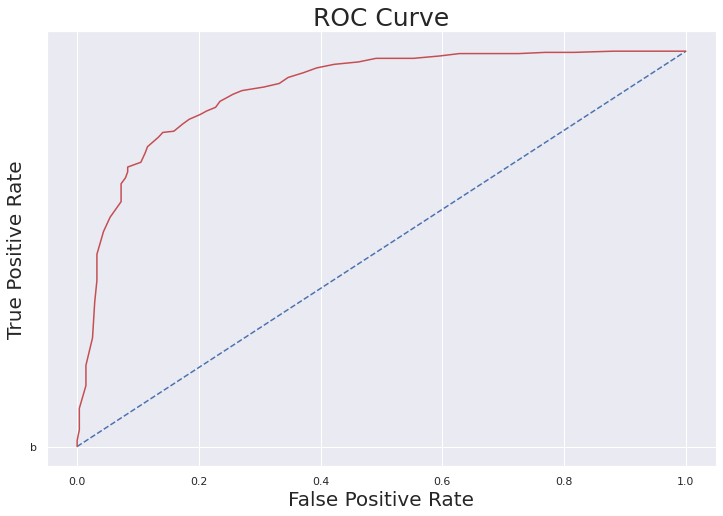

In [19]:
print(f'Train ROC AUC Score: {roc_auc_score(train_labels, train_rf_probs)}')
print(f'Test ROC AUC  Score: {roc_auc_score(test_labels, rf_probs)}')
evaluate_model(rf_predictions, rf_probs, train_rf_predictions, train_rf_probs)

## Feature Importances

In [23]:
fi = pd.DataFrame({'feature': features,
                   'importance': model.feature_importances_}).\
                    sort_values('importance', ascending = False)
fi[:10] #first ten most valuable information for the classification

,feature,importance
23,artist_popularity,0.292734
10,loudness,0.068091
13,acousticness,0.050818
22,dzGain,0.046502
8,energy,0.044867
2,duration_ms,0.042756
17,tempo,0.038533
12,speechiness,0.036251
14,instrumentalness,0.036033
7,danceability,0.034833


## Confusion Matrix

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    
    # Labeling the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), fontsize = 20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.grid(None)
    plt.tight_layout()
    plt.ylabel('True label', size = 18)
    plt.xlabel('Predicted label', size = 18)
    
def plot_heatmap(df,title,filename=False,max_ = False):
    
    L = 2
    plt.figure(figsize=(10,10))
    sns.set(font_scale=1.4)
    if(not max_):
        max_value = df.fillna(0).max().max()
    else:
        max_value = max_
    sns.heatmap(df.fillna(0), vmin=0, vmax=max_value,linewidths=4,annot=True, fmt="d",cmap="YlGnBu")
    
    plt.title(title,fontsize = 30)
    plt.yticks(np.arange(L)+0.5,['Above (T)','Below (T)'], rotation=90, fontsize="15",weight = 'bold', va="center")
    plt.xticks(np.arange(L)+0.5,['Above (P)','Below (P)'], rotation=0, fontsize="15",weight = 'bold', va="center")
    plt.ylim(L+0., -0.)
    plt.plot()
    if(filename):
        plt.savefig('Tesi/ImgTesi/RandomForest/'+filename + '.png')
    return 

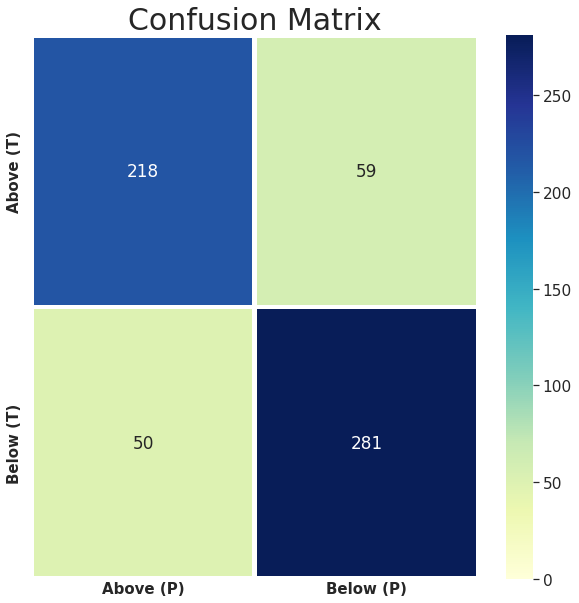

In [30]:
cm = confusion_matrix(test_labels, rf_predictions)
plot_heatmap(pd.DataFrame(cm),'Confusion Matrix',filename='confusion')